In [1]:
import scipy.io, math, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
from tslearn.datasets import CachedDatasets

In [3]:
def get_srate(file_number):
    directory = 'data/Data/F1/mat'
    
    # still needs to ignore the .DS_Store file in a better way
    file = sorted(os.listdir(directory))[file_number + 1]
    
    f = os.path.join(directory, file)
    mat = scipy.io.loadmat(f)['usctimit_ema_f1_{:03}_{:03}'.format(file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is stored here
    return mat[0][1][1][0][0]

In [4]:
def get_pos_list(position, dimension, file_number, starting_point, end_point):
    values = []
    if dimension == 'x':
        dim = 0
    elif dimension == 'y':
        dim = 1 
    elif dimension == 'z':
        dim = 2

    if position == 'UL':
        for i in range(end_point - starting_point):
            coordinate = (UL_df[file_number][dim][starting_point + i])
            values.append(coordinate)
            
    if position == 'LL':
        for i in range(end_point - starting_point):
            coordinate = (LL_df[file_number][dim][starting_point + i])
            values.append(coordinate)
            
    if position == 'JW':
        for i in range(end_point - starting_point):
            coordinate = (JW_df[file_number][dim][starting_point + i])
            values.append(coordinate)
            
    if position == 'TB':
        for i in range(end_point - starting_point):
            coordinate = (TB_df[file_number][dim][starting_point + i])
            values.append(coordinate)
            
    if position == 'TD':
        for i in range(end_point - starting_point):
            coordinate = (TD_df[file_number][dim][starting_point + i])
            values.append(coordinate)
            
    if position == 'TT':
        for i in range(end_point - starting_point):
            coordinate = (TT_df[file_number][dim][starting_point + i])
            values.append(coordinate)
        
    return values

In [31]:
def get_key(val, dictionary):
    instances = []
    
    # retrieves the numbers of the instances of the word we are looking for in a list
    for key, value in dictionary.items():
        if val == value['word'][0]:
            instances.append(key)
    
    return instances

In [5]:
directory = 'data/Data/F1/mat'
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df = [], [], [], [], [], []

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_f1_{:03}_{:03}'.format(counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))

In [7]:
frames = {}
word_number = 0

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for line in timestamps:
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        
        # find start and end by multiplying the timestamps with the sampling rate
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        end_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # make dataframe for each word, so 3481 dataframes
        data = {'word' : [split_line[1]],
                'srate': [get_srate(int(split_line[0]))],
                'sent' : [int(split_line[-1])],
                'ULx'  : [get_pos_list('UL', 'x', int(split_line[0]), starting_point, end_point)],
                'ULy'  : [get_pos_list('UL', 'y', int(split_line[0]), starting_point, end_point)],
                'LLx'  : [get_pos_list('LL', 'x', int(split_line[0]), starting_point, end_point)],
                'LLy'  : [get_pos_list('LL', 'y', int(split_line[0]), starting_point, end_point)],
                'JWx'  : [get_pos_list('JW', 'x', int(split_line[0]), starting_point, end_point)],
                'JWy'  : [get_pos_list('JW', 'y', int(split_line[0]), starting_point, end_point)],
                'TDx'  : [get_pos_list('TD', 'x', int(split_line[0]), starting_point, end_point)],
                'TDy'  : [get_pos_list('TD', 'y', int(split_line[0]), starting_point, end_point)],
                'TBx'  : [get_pos_list('TB', 'x', int(split_line[0]), starting_point, end_point)],
                'TBy'  : [get_pos_list('TB', 'y', int(split_line[0]), starting_point, end_point)],
                'TTx'  : [get_pos_list('TT', 'x', int(split_line[0]), starting_point, end_point)],
                'TTy'  : [get_pos_list('TT', 'y', int(split_line[0]), starting_point, end_point)]}
        
        df = pd.DataFrame(data)
        frames[word_number] = df
        word_number += 1

In [32]:
word_instances = {}

for frame in frames:
    if frames[frame]['word'][0] in word_instances:
        continue
    
    word_instances[frames[frame]['word'][0]] = get_key(frames[frame]['word'][0], frames)

/Users/evankemmer/opt/anaconda3/lib/python3.9/site-packages/tslearn/barycenters/softdtw.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_ = numpy.array([to_time_series(d, remove_nans=True) for d in X_])


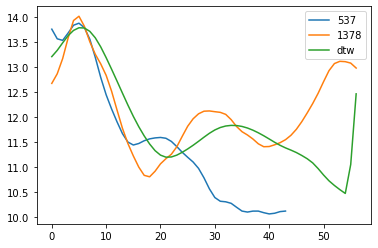

In [30]:
# find the average of two instances of the word 'project'
dtw_project = softdtw_barycenter([frames[537]['ULx'][0], frames[1378]['ULx'][0]], gamma=1)

plt.plot(frames[537 ]['ULx'][0], label = '537')
plt.plot(frames[1378]['ULx'][0], label = '1378')
plt.plot(dtw_project, label = 'dtw')
         
plt.legend()
plt.show()